# Cartopy tutorial: Transforming raster to vector

The most common raster to vector transformation is contouring. In addition to that though, there are a number of image processing techniques for identifying features of interest.


### Contouring
Let's start with contouring:

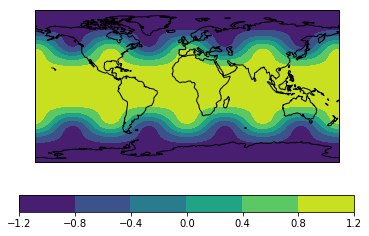

In [103]:
import cartopy.crs as ccrs
from cartopy.examples.waves import sample_data
import matplotlib.pyplot as plt

lons, lats, data = sample_data()

ax = plt.axes(projection=ccrs.PlateCarree())
cs = plt.contourf(
    lons, lats, data, 5,
    transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(orientation='horizontal')
plt.show()

Let's pick out one of these contours. We could choose to pick out a line (``contour``) or a polygon (``contourf``).
Since we have already produce filled contours, let's use those:

In [104]:
print(cs.levels)
print('N levels: {}'.format(len(cs.levels)))
print('N collections: {}'.format(len(cs.collections)))

[-1.2 -0.8 -0.4  0.   0.4  0.8  1.2]
N levels: 7
N collections: 6


In [108]:
print(cs.levels[4:6])
print(cs.collections[4])
paths = cs.collections[4].get_paths()

[0.4 0.8]


We now need to convert these matplotlib Paths into Shapely geometries. The [``descartes``](https://pypi.org/project/descartes/) package is designed to do precisely this, but cartopy also has such functionality that has been tuned for performance:

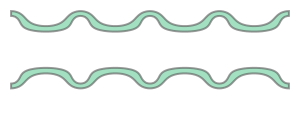

In [110]:
from cartopy.mpl.patch import path_to_geos, geos_to_path
import shapely.ops

# Produces a list of shapely geometries.
geoms = []
for path in paths:
    geoms.extend(path_to_geos(path))

# Flatten the whole thing down to a single MultiPolygon
polygon = shapely.ops.unary_union(geoms)
polygon

We could use this geometry for any number of vector-type operations, but for now, let's just save it to disk. GeoJSON is a good choice for this kind of geometry - GeoJSON has become ubiquitous on the internet for its simpliciy and its interoperability with a number of popular tools/frameworks (including GitHub).

In [115]:
import json
import shapely.geometry as sgeom


with open('contour.geojson', 'w') as fh:
    json.dump(sgeom.mapping(polygon), fh)

We've uploaded this geojson to a GitHub gist to show how GitHub renders this file: https://gist.github.com/pelson/837ca8c01d38157a2d634dcf97260e45

Be aware that the GeoJSON specification states that geometries MUST be saved in WGS84. The default PlateCarree instance is in fact equivalent to WGS84, so in this case we didn't need to convert the geometry. If had needed to convert it we could project the geometry with ``ccrs.PlateCarree().project_geometry(geometry, source_crs)``.

### Data space vs pixel space

So far we have used ``matplotlib.contour[f]`` to produce our contours, which conveniently returns contours in *data* coordinates. Sometimes we want to use tools that don't work in coordinate space, and which simply return pixel locations.

In [121]:
import skimage.feature
import skimage.color
import skimage.io

atw80d = skimage.io.imread('../../resources/640px-Around_the_World_in_Eighty_Days_map.png')

features = skimage.feature.blob_doh(
    skimage.color.rgb2gray(atw80d),
    min_sigma=3)
features

array([[280., 624.,  30.],
       [129., 403.,   3.],
       [125., 517.,   3.],
       [122., 434.,   3.],
       [120., 484.,   3.],
       [104., 324.,   3.],
       [ 94., 521.,   3.],
       [ 93., 137.,   3.],
       [ 89.,  39.,   3.],
       [ 82., 128.,   3.],
       [ 59., 263.,   3.]])

The result of this skimage blob detection algorithm is an array of pixel locations.
Conversion between pixel locations and data locations is currently quite manual.
The following function is mostly borrowed from the [mpldatacursor](https://github.com/joferkington/mpldatacursor) project:

### Skeletonization

Exercise: Extract contours from a raster, save to GeoJSON.

*Exercise:* Pull out the route from the wikipedia image.

*Exercise:* Project the geometry to PC, so that we can save it to GeoJSON.